<h1 align="center">Fair training</h1>

<h4 align="right">Prof. Changho Suh, TA Jaewoong Cho, Gyeongjo Hwang</h4>

### 실습목표
- Fairness metric 중 하나인 disparate impact을 측정하는 코드 구현
- Fair dataset과 unfair dataset을 생성
- 각각의 데이터셋에 logistic regression을 적용한 뒤 성능 및 fairness를 측정
- Zafar의 fair training 알고리즘 코드 구현 <href>https://arxiv.org/pdf/1507.05259.pdf</href>
 - Lambda가 주어졌을 때, (Cross entropy loss) + lambda * (fairness regularization term)을 최소화하는 gradient descent 알고리즘 구현
- Unfair dataset에 Zafar 알고리즘 기반 logistic regression을 적용한 뒤 성능 및 fairness 측정, lambda 값에 따른 tradeoff 그래프를 작성

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

from fair_utils import generate_unfair_data, plot_unfair_data, Normalize, sigmoid, \
initialize_with_zeros, Logistic, forward, draw_boundary

In [17]:
(X_train, Y_train, z_train), (X_test, Y_test, z_test) = generate_unfair_data(
    n_samples=5000,
    disc_factor=math.pi/8.0) # decrease the discrimination factor to generate more unfair data

In [18]:
print(X_train.shape, Y_train.shape, z_train.shape)
print(X_test.shape, Y_test.shape, z_test.shape)

(2, 4000) (4000,) (4000,)
(2, 1000) (1000,) (1000,)


In [19]:
X_train = Normalize(X_train)
X_test = Normalize(X_test)

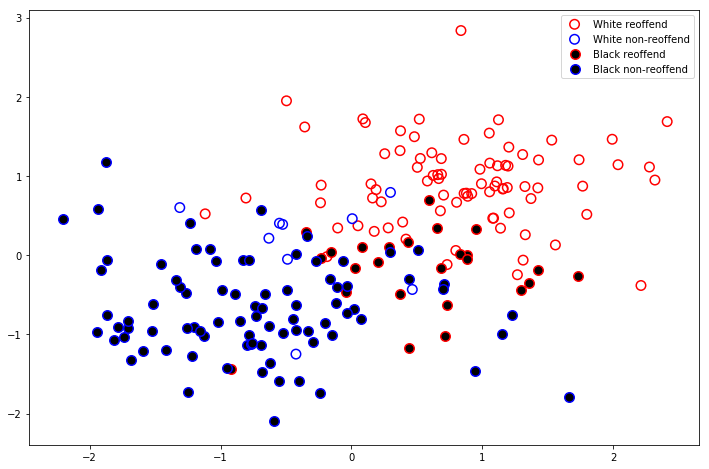

In [20]:
plt.figure(figsize=(12,8))
plot_unfair_data(X_train.T, Y_train, z_train)
plt.show()

In [21]:
d = Logistic(X_train, Y_train, X_test, Y_test, print_cost=True)
print(d["test_acc"])

Cost after iteration [2000/2000]: 0.184310
train accuracy: 92.575 %
test accuracy: 93.5 %
93.5


### Disparate impact

#### 실습문제) Disparate impact를 측정하는 함수를 구현하시오.
- Logistic regression의 forward 함수와 이를 통해 얻은 prediction $\hat{y}$은 아래에 제공.
- 

In [22]:
def measure_disparate_impact(w, b, X, Y, z):
    Yhat, _ = forward(w, b, X, Y)
    Ytilde = np.round(Yhat.reshape(-1))
    
    ### START CODE HERE ###
    z_0_mask = (z == 0.0)
    z_1_mask = (z == 1.0)
    z_0_sum = np.sum(z_0_mask)
    z_1_sum = np.sum(z_1_mask)
    
    Ytilde_1_z_0 = (Ytilde == 1.0)[z_0_mask]
    Ytilde_1_z_1 = (Ytilde == 1.0)[z_1_mask]
    Ytilde_1_z_0_sum = np.sum(Ytilde_1_z_0)
    Ytilde_1_z_1_sum = np.sum(Ytilde_1_z_1)
    
    ratio1 = Ytilde_1_z_0_sum / z_1_sum
    ratio2 = Ytilde_1_z_1_sum / z_0_sum
    ### END CODE HERE ###
    
    DI = min(ratio1, ratio2)
    return DI

In [23]:
print(measure_disparate_impact(d["w"], d["b"], X_test, Y_test, z_test))

0.17857142857142858


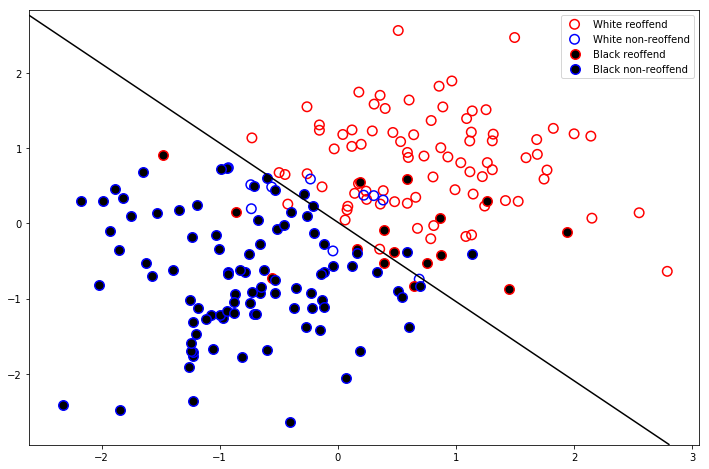

In [24]:
plt.figure(figsize=(12,8))
draw_boundary(d["w"], d["b"], X_test, Y_test, z_test, title='Test data', colormap=False)
plt.show()

In [25]:
def forward_fair(w, b, X, Y, z, lambda_):
    m = X.shape[1]
    Yhat = sigmoid(np.dot(w.T, X) + b)
    cross_entropy = (- 1 / m) * np.sum(Y * np.log(Yhat) + (1 - Y) * (np.log(1 - Yhat)))
    
    ### START CODE HERE ###
    z_bar = np.mean(z)
    covar = (1 / m) * np.sum((z - z_bar) * (np.dot(w.T, X) + b))
    ### END CODE HERE ###
    
    cost = cross_entropy + lambda_ * np.abs(covar)
    return Yhat, cost, covar

In [26]:
def backward_fair(w, b, X, Y, z, Yhat, covar, lambda_):
    m = X.shape[1]
    z_bar = np.mean(z)
    
    ### START CODE HERE ###
    sign = 1.0 if covar > 0 else -1.0
    dw = (1 / m) * np.dot(X, (Yhat - Y).T) + lambda_ * (1 / m) * sign * np.dot(X, (z - z_bar).reshape(-1, 1))
    db = (1 / m) * np.sum(Yhat - Y)
    ### END CODE HERE ###
    
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    
    grads = {"dw": dw, "db": db}
    return grads

In [27]:
def fit_fair(w, b, X, Y, z, num_iterations, lambda_, learning_rate, print_cost=False):
    costs = []
    
    for i in range(num_iterations):
        # Cost and gradient calculation
        Yhat, cost, covar = forward_fair(w, b, X, Y, z, lambda_)
        grads = backward_fair(w, b, X, Y, z, Yhat, covar, lambda_)
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule (≈ 2 lines of code)
        w = w - learning_rate * dw  # need to broadcast
        b = b - learning_rate * db
        
        # Record the costs
        if i % 10 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training examples
        if print_cost and (i + 1) % 10 == 0 or (i + 1) == num_iterations:
            print ("Cost after iteration [%i/%i]: %f" % (i + 1, num_iterations, cost), end='\r')
    params = {"w": w, "b": b}
    
    return params, costs

In [28]:
def predict_fair(w, b, X):
    m = X.shape[1]
    assert(w.shape[0] == X.shape[0])
    
    Yhat = sigmoid(np.dot(w.T, X) + b)
    Yhat[Yhat > 0.5] = 1
    Yhat[Yhat <= 0.5] = 0
    Y_prediction = Yhat
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [29]:
def Logistic_fair(X, Y, z, X_test, Y_test, z_test, num_iterations, lambda_, learning_rate, print_cost=False):
    w, b = initialize_with_zeros(X_train.shape[0])
    
    parameters, costs = fit_fair(w, b, X, Y, z, num_iterations, lambda_, learning_rate, print_cost)
    
    w = parameters["w"]
    b = parameters["b"]
    
    Y_prediction_test = predict_fair(w, b, X_test)
    Y_prediction_train = predict_fair(w, b, X_train)
    
    train_acc = 100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100
    test_acc = 100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100
    DI = measure_disparate_impact(w, b, X_test, Y_test, z_test)

    print("train accuracy: {} %".format(train_acc))
    print("test accuracy: {} %".format(test_acc))
    print("disparate impact: {:.3f}".format(DI))
    print()

    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test,
         "Y_prediction_train" : Y_prediction_train,
         "train_acc": train_acc,
         "test_acc": test_acc,
         "DI": DI,
         "w" : w,
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [30]:
acc_fairness = []
model_history = []
lambda_range = np.linspace(0, 1.05, 31)
# fig, axes = plt.subplots(11)
# plt.figure(figsize=(16,12))
for i, lambda_ in enumerate(lambda_range):
    d = Logistic_fair(X_train, Y_train, z_train, X_test, Y_test, z_test, 3000, lambda_, learning_rate=1e-5, print_cost=False)
    
    # axes[i].plot(range(200), d["costs"])
    acc_fairness.append((lambda_, d["test_acc"], d["DI"]))
    model_history.append(d)

train accuracy: 92.45 %000/3000]: 0.685647
test accuracy: 93.5 %
disparate impact: 0.179

train accuracy: 92.475 %00/3000]: 0.686134
test accuracy: 93.4 %
disparate impact: 0.181

train accuracy: 92.475 %00/3000]: 0.686605
test accuracy: 93.4 %
disparate impact: 0.181

train accuracy: 92.5 %3000/3000]: 0.687059
test accuracy: 93.4 %
disparate impact: 0.181

train accuracy: 92.5 %3000/3000]: 0.687496
test accuracy: 93.4 %
disparate impact: 0.181

train accuracy: 92.55 %000/3000]: 0.687917
test accuracy: 93.4 %
disparate impact: 0.181

train accuracy: 92.525 %00/3000]: 0.688321
test accuracy: 93.5 %
disparate impact: 0.179

train accuracy: 92.55 %000/3000]: 0.688709
test accuracy: 93.5 %
disparate impact: 0.179

train accuracy: 92.6 %3000/3000]: 0.689080
test accuracy: 93.4 %
disparate impact: 0.179

train accuracy: 92.575 %00/3000]: 0.689435
test accuracy: 93.3 %
disparate impact: 0.181

train accuracy: 92.575 %00/3000]: 0.689773
test accuracy: 93.4 %
disparate impact: 0.183

train accu

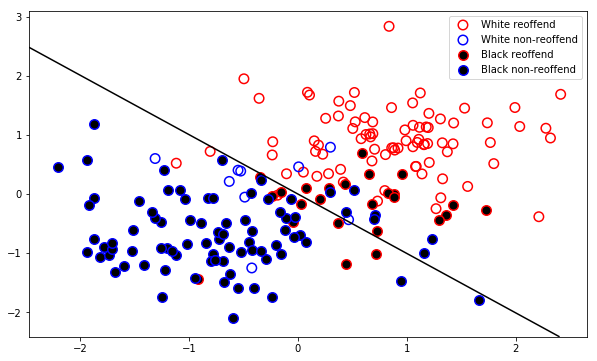

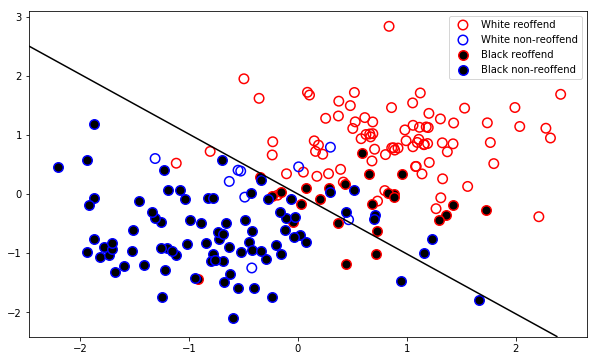

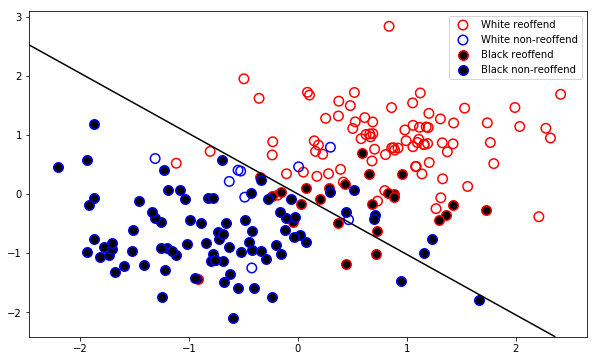

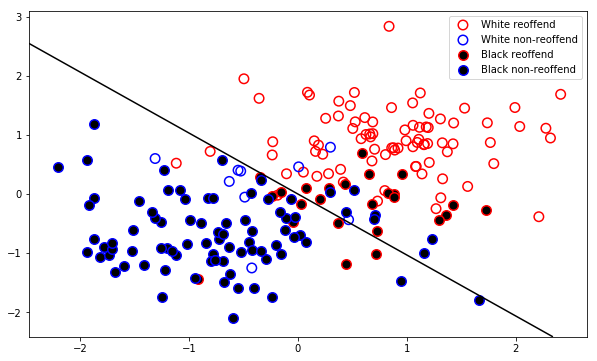

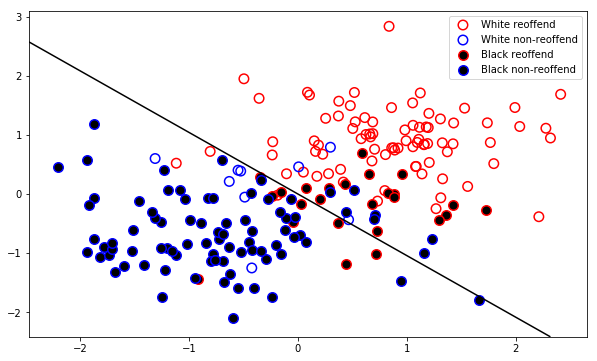

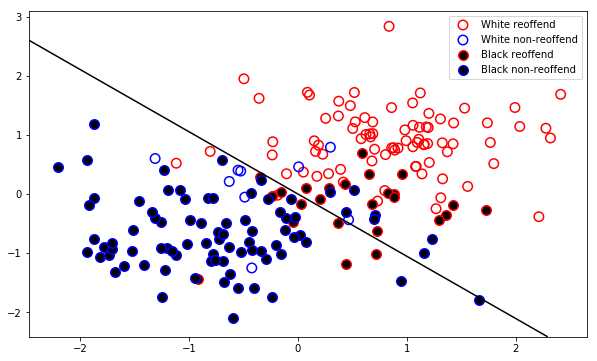

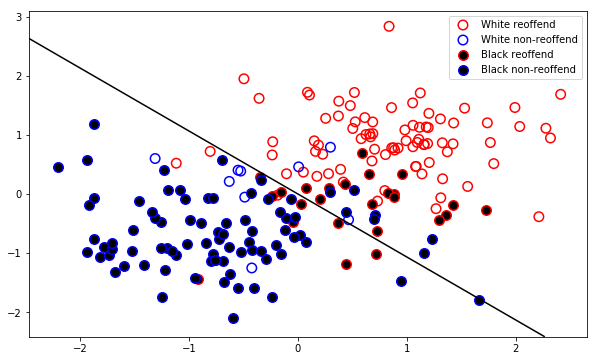

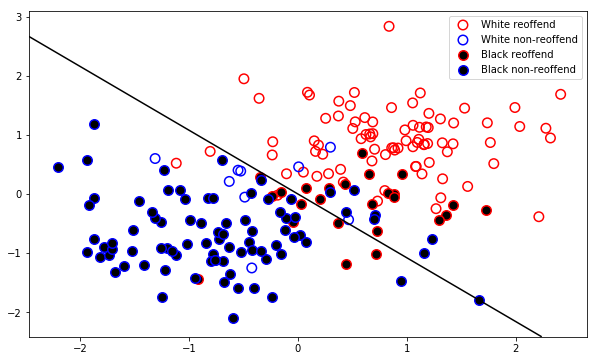

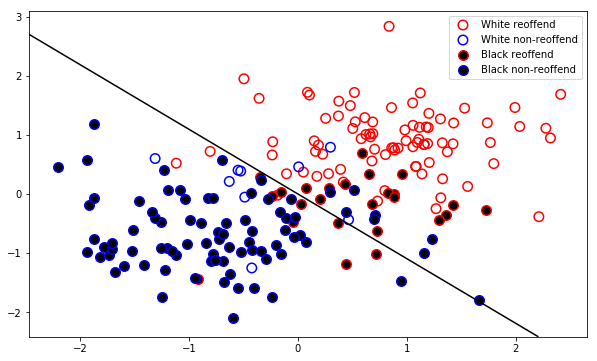

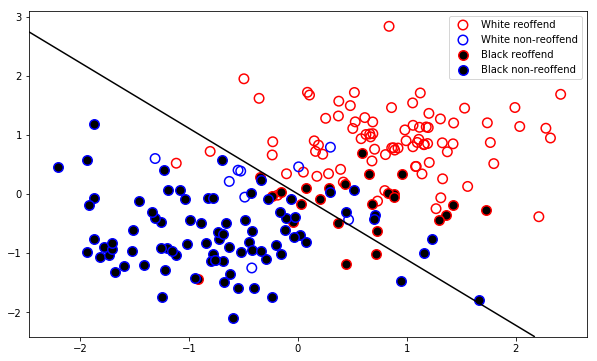

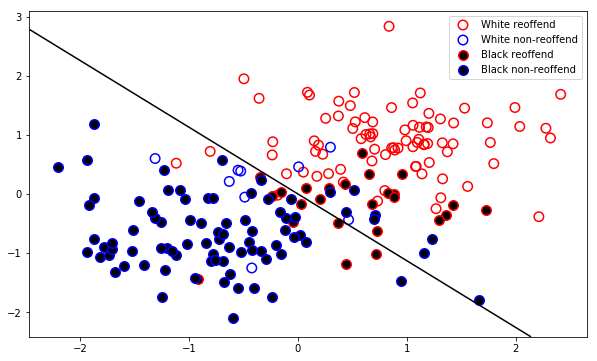

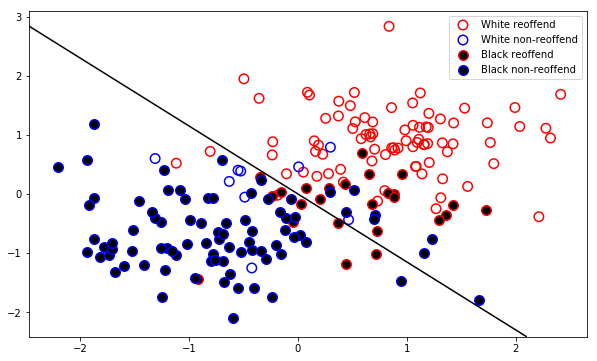

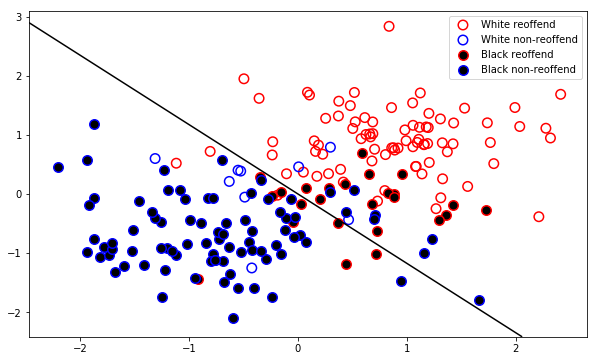

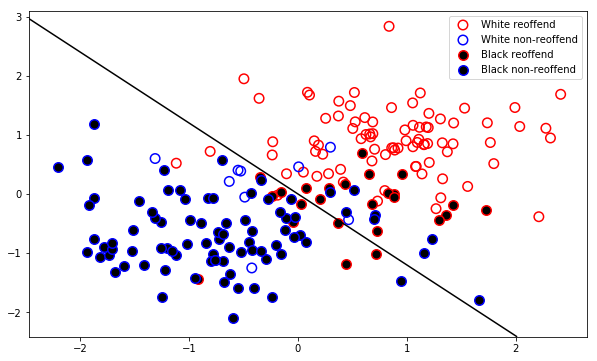

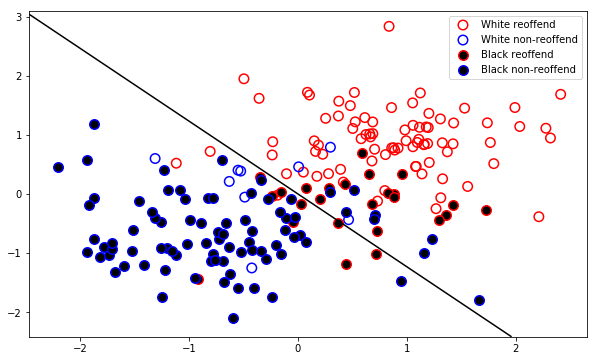

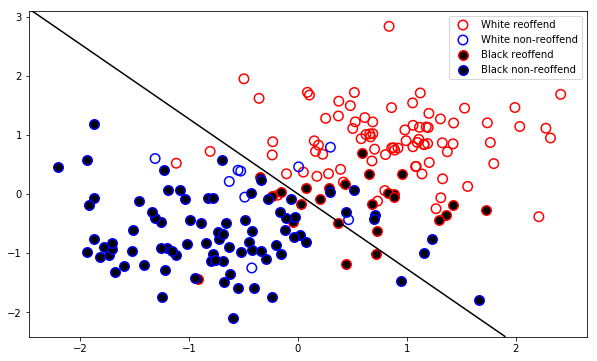

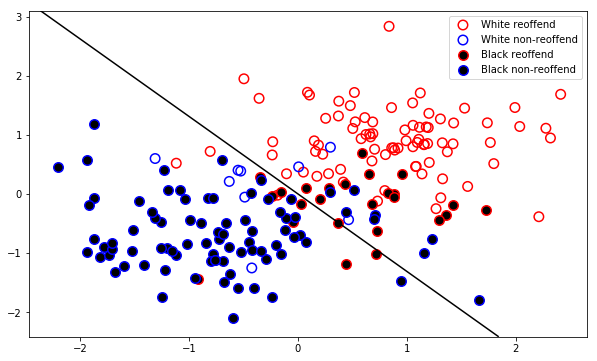

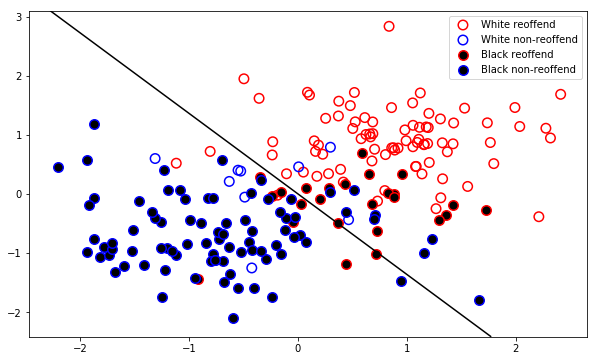

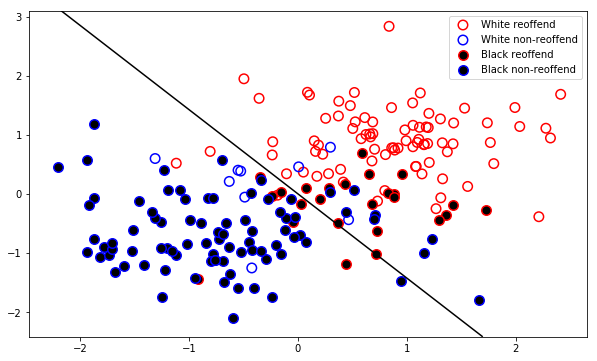

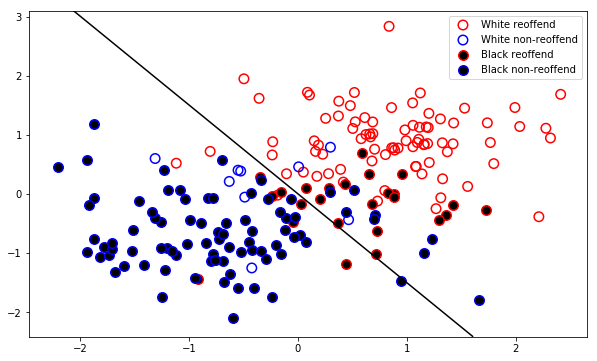

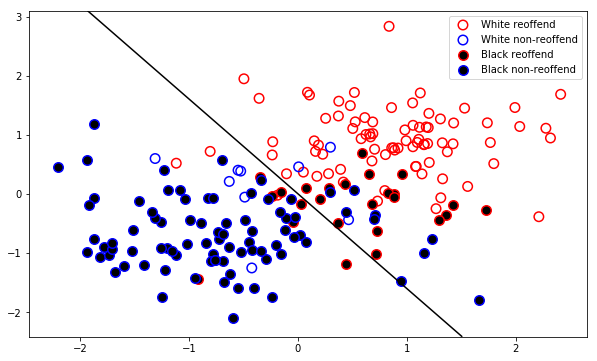

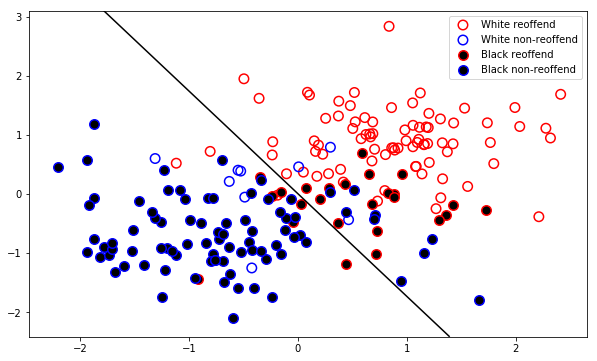

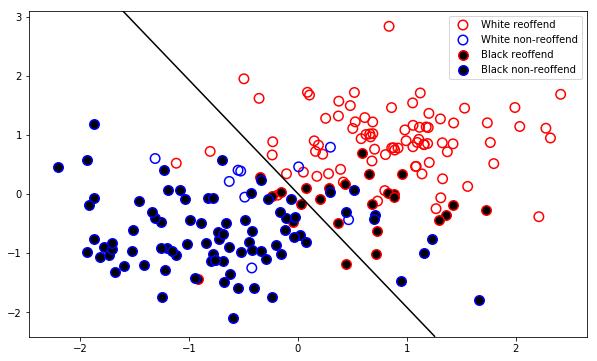

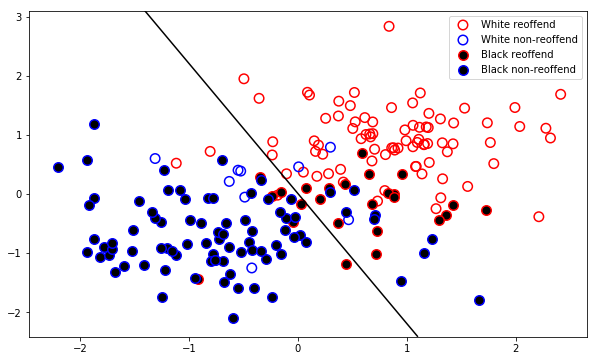

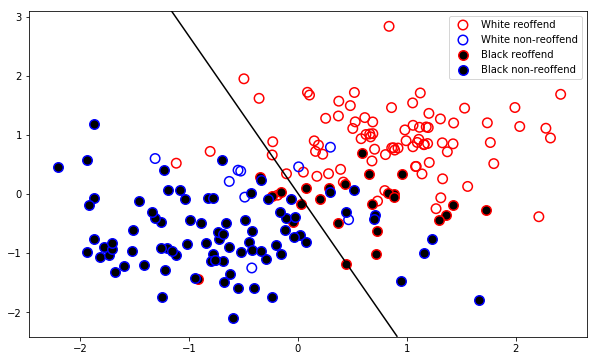

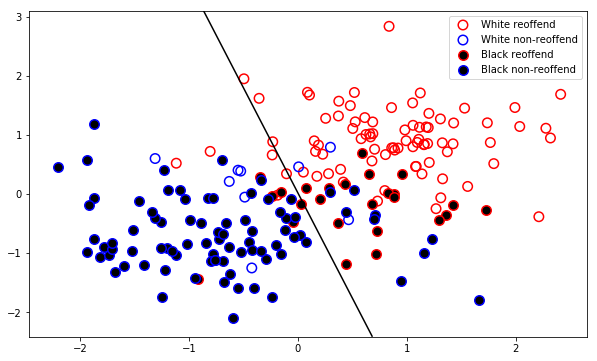

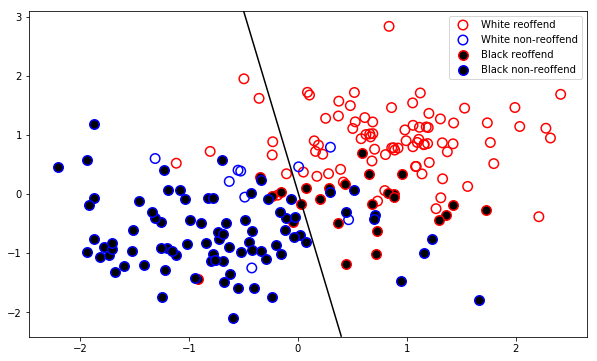

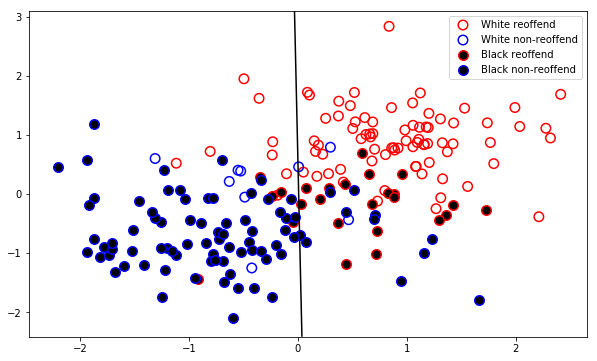

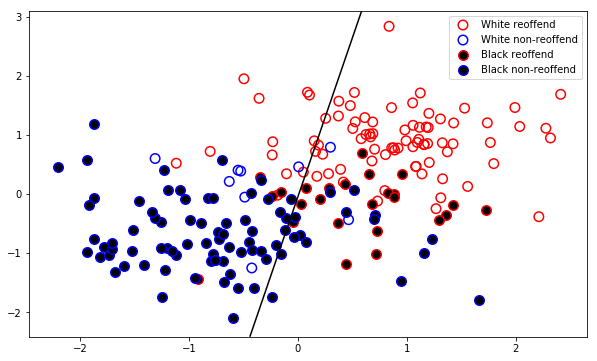

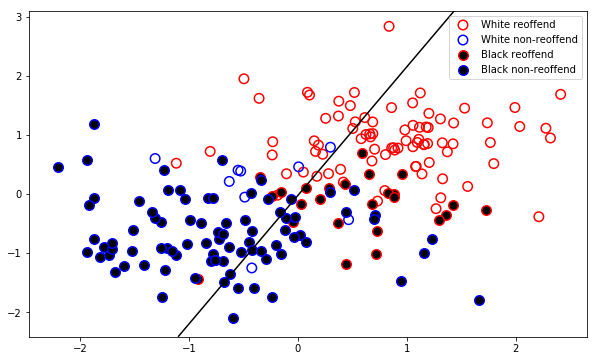

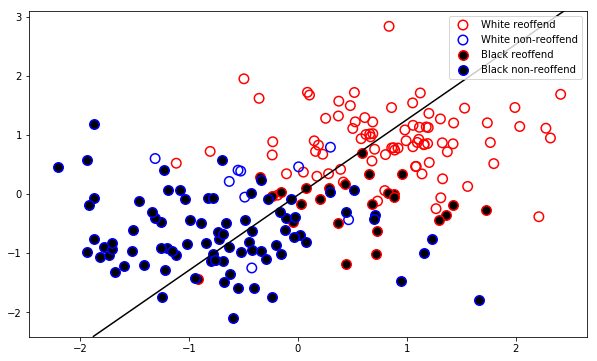

In [31]:
for d in model_history:
    w, b = d["w"], d["b"]
    
    plt.figure(figsize=(10,6))
    draw_boundary(w, b, X_train, Y_train, z_train)
    plt.show()

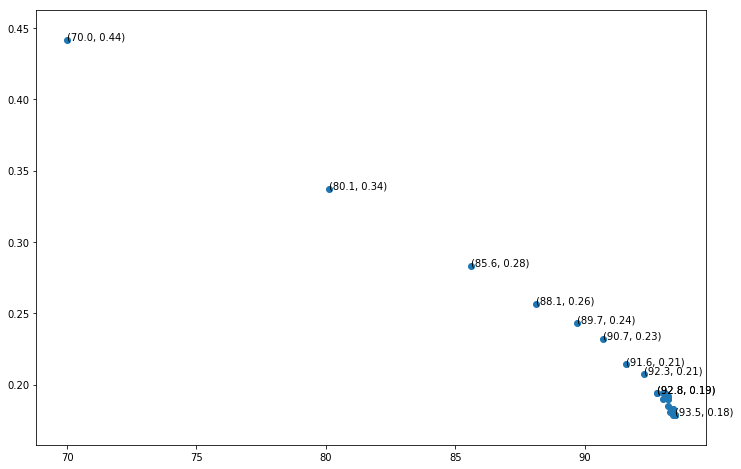

In [45]:
acc_fairness_np = np.array(acc_fairness)
plt.figure(figsize=(12,8))
plt.scatter(acc_fairness_np[:-1, 1], acc_fairness_np[:-1, 2])
x, y = acc_fairness_np[:-1, 1], acc_fairness_np[:-1, 2]
axes = plt.gca()
for i, xy in enumerate(zip(x,y)):
    if 0 < i and i < 20:
        continue
    axes.annotate("({:.1f}, {:.2f})".format(float(xy[0]), float(xy[1])), xy=xy, textcoords="data")
plt.show()

In [42]:
acc_fairness

[(0.0, 93.5, 0.17857142857142858),
 (0.035, 93.4, 0.18080357142857142),
 (0.07, 93.4, 0.18080357142857142),
 (0.10500000000000001, 93.4, 0.18080357142857142),
 (0.14, 93.4, 0.18080357142857142),
 (0.17500000000000002, 93.4, 0.18080357142857142),
 (0.21000000000000002, 93.5, 0.17857142857142858),
 (0.24500000000000002, 93.5, 0.17857142857142858),
 (0.28, 93.4, 0.17857142857142858),
 (0.31500000000000006, 93.3, 0.18080357142857142),
 (0.35000000000000003, 93.4, 0.18303571428571427),
 (0.385, 93.4, 0.18303571428571427),
 (0.42000000000000004, 93.2, 0.18526785714285715),
 (0.45500000000000007, 93.2, 0.18973214285714285),
 (0.49000000000000005, 93.2, 0.18973214285714285),
 (0.525, 93.0, 0.18973214285714285),
 (0.56, 93.1, 0.19419642857142858),
 (0.5950000000000001, 93.0, 0.19419642857142858),
 (0.6300000000000001, 93.2, 0.19196428571428573),
 (0.665, 93.1, 0.19196428571428573),
 (0.7000000000000001, 92.8, 0.19419642857142858),
 (0.7350000000000001, 92.8, 0.19419642857142858),
 (0.77, 92.3, 